In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import energy_distance, wasserstein_distance
import numpy as np
import pandas as pd

torch.manual_seed(538)

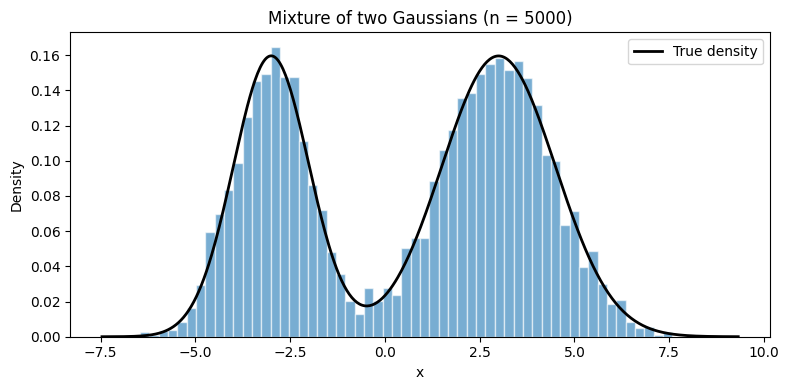

Sample mean: 0.563, Sample std: 3.215


In [2]:
# Mixture parameters
n = 5000
pi = 0.4            # mixing weight for component 1
mu1, sigma1 = -3.0, 1.0  # component 1: N(-3, 1)
mu2, sigma2 = -mu1, 1.5   # component 2: N(3, 1.5^2)

# Sample component assignments, then draw from the chosen component
z = torch.bernoulli(torch.full((n,), pi))
x = torch.where(z == 1,
                torch.normal(mu1, sigma1, size=(n,)),
                torch.normal(mu2, sigma2, size=(n,)))

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(x.numpy(), bins=60, density=True, alpha=0.6, edgecolor="white")
t = torch.linspace(x.min() - 1, x.max() + 1, 500)

from scipy.stats import norm
density = pi * norm.pdf(t.numpy(), mu1, sigma1) + (1 - pi) * norm.pdf(t.numpy(), mu2, sigma2)
ax.plot(t.numpy(), density, "k-", lw=2, label="True density")
ax.set_xlabel("x")
ax.set_ylabel("Density")
ax.set_title(f"Mixture of two Gaussians (n = {n})")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Sample mean: {x.mean():.3f}, Sample std: {x.std():.3f}")

In [3]:
@torch.no_grad()
def sample_from_G(G, n=5000, z_dim=8, device="cpu"):
    z = torch.randn(n, z_dim, device=device)
    return G(z).cpu()

def evaluate_and_plot(x_test, x_gen, bins=60, title="True vs Generated"):
    # Distances (scipy.stats)
    ed = energy_distance(x_test, x_gen)
    wd = wasserstein_distance(x_test, x_gen)

    print(f"Energy distance:      {ed:.6f}")
    print(f"Wasserstein distance: {wd:.6f}")

    # Histogram overlay
    plt.figure(figsize=(8, 4))
    plt.hist(x_test, bins=bins, density=True, alpha=0.5, label="True test (n=5000)")
    plt.hist(x_gen,  bins=bins, density=True, alpha=0.5, label="Generated (n=5000)")
    plt.legend()
    plt.title(title + f"\nED={ed:.4f}, WD={wd:.4f}")
    plt.xlabel("x")
    plt.ylabel("density")
    plt.tight_layout()
    plt.show()

    return ed, wd

### Method 1: Engression

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=8, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden, 1),
        )

    def forward(self, z):
        return self.net(z).squeeze(-1)  # (B,)

# -------------------------
# Engression loss (unconditional, 1D)
# -------------------------
def engression_loss(x_batch, G, z_dim=8, m=8):
    """
    x_batch: (B,)
    We draw m noises per x_i: z_{i,1..m}, generate yhat_{i,1..m}.
    term1 = mean_{i} mean_{j} |x_i - yhat_{i,j}|
    term2 = mean_{i} mean_{j<k} |yhat_{i,j} - yhat_{i,k}|
    loss = term1 - 0.5 * term2
    """
    B = x_batch.shape[0]
    # (B, m, z_dim)
    z = torch.randn(B, m, z_dim, device=x_batch.device)
    yhat = G(z.view(B * m, z_dim)).view(B, m)  # (B, m)

    term1 = (yhat - x_batch[:, None]).abs().mean()

    # pairwise absolute differences within each i (B, m, m)
    diffs = (yhat[:, :, None] - yhat[:, None, :]).abs()
    # average over j<k (avoid diagonal / double counting)
    # mask upper triangle
    triu_mask = torch.triu(torch.ones(m, m, device=x_batch.device), diagonal=1).bool()
    term2 = diffs[:, triu_mask].mean()

    return term1 - 0.5 * term2

def train_engression(x, steps=4000, batch_size=256, lr=2e-4, z_dim=8, m=8, device="cpu"):
    ds = TensorDataset(x.to(device))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

    G = Generator(z_dim=z_dim).to(device)
    opt = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))

    it = 0
    while it < steps:
        for (xb,) in dl:
            opt.zero_grad()
            loss = engression_loss(xb, G, z_dim=z_dim, m=m)
            loss.backward()
            opt.step()

            it += 1
            if it % 500 == 0:
                print(f"[Engression] step={it:5d}  loss={loss.item():.4f}")
            if it >= steps:
                break
    return G

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
G = train_engression(x, steps=4000, batch_size=256, lr=2e-4, z_dim=8, m=8, device=device)

[Engression] step=  500  loss=1.9334
[Engression] step= 1000  loss=1.8794
[Engression] step= 1500  loss=1.8742
[Engression] step= 2000  loss=1.7813
[Engression] step= 2500  loss=1.8966
[Engression] step= 3000  loss=1.8471
[Engression] step= 3500  loss=1.8413
[Engression] step= 4000  loss=1.8560


Generated mean/std: 0.38599422574043274 3.250605583190918
Energy distance:      0.125994
Wasserstein distance: 0.234222


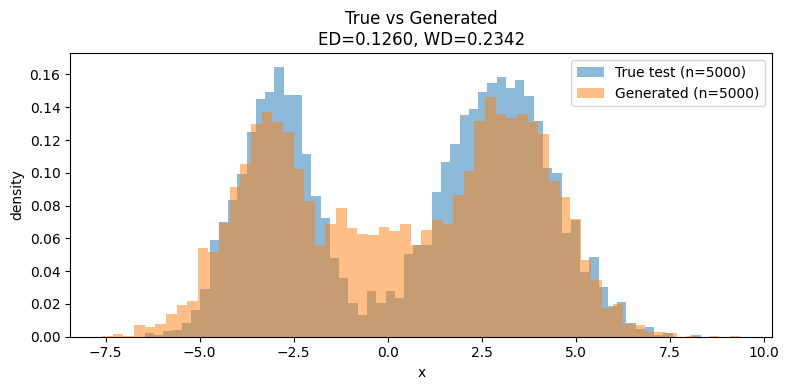

(np.float64(0.12599381414309452), np.float64(0.2342217534661294))

In [6]:
x_fake = sample_from_G(G, n=5000, z_dim=8, device=device)
print("Generated mean/std:", x_fake.mean().item(), x_fake.std().item())
evaluate_and_plot(x, x_fake)

### Method 2: normalizing flow

In [7]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# -------------------------
# True data generator (match your notebook params)
# -------------------------
def sample_mog_torch(n=5000, pi=0.4, mu1=-3.0, sigma1=1.0, mu2=3.0, sigma2=1.5, seed=538, device="cpu"):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    z = torch.bernoulli(torch.full((n,), pi, device=device), generator=g)
    x = torch.where(
        z == 1,
        torch.normal(mu1, sigma1, size=(n,), generator=g, device=device),
        torch.normal(mu2, sigma2, size=(n,), generator=g, device=device),
    )
    return x

# -------------------------
# Utilities: normal log prob
# -------------------------
def standard_normal_logprob(z):
    return -0.5 * (math.log(2 * math.pi) + z**2)

# -------------------------
# 1D Rational-Quadratic Spline Flow (global params)
# Domain: [-B, B] with linear tails
# Reference: Durkan et al. (but implemented directly here)
# -------------------------
class SplineFlow1D(nn.Module):
    def __init__(self, K=32, B=8.0, min_bin_width=1e-3, min_bin_height=1e-3, min_derivative=1e-3):
        super().__init__()
        self.K = K
        self.B = float(B)
        self.min_bin_width = min_bin_width
        self.min_bin_height = min_bin_height
        self.min_derivative = min_derivative

        # Unconstrained parameters; we’ll transform them to valid widths/heights/derivatives
        self.unnorm_widths = nn.Parameter(torch.zeros(K))
        self.unnorm_heights = nn.Parameter(torch.zeros(K))
        self.unnorm_derivs = nn.Parameter(torch.zeros(K + 1))

    def _params(self, device):
        # widths/heights positive and sum to 2B across bins
        widths = torch.softmax(self.unnorm_widths, dim=0)
        widths = self.min_bin_width + (2*self.B - self.K*self.min_bin_width) * widths

        heights = torch.softmax(self.unnorm_heights, dim=0)
        heights = self.min_bin_height + (2*self.B - self.K*self.min_bin_height) * heights

        derivs = torch.nn.functional.softplus(self.unnorm_derivs) + self.min_derivative
        return widths.to(device), heights.to(device), derivs.to(device)

    def _knot_positions(self, widths, heights):
        # knots in x and y space, both spanning [-B, B]
        xk = torch.cumsum(torch.cat([torch.tensor([0.0], device=widths.device), widths]), dim=0) - self.B
        yk = torch.cumsum(torch.cat([torch.tensor([0.0], device=heights.device), heights]), dim=0) - self.B
        return xk, yk  # (K+1,), (K+1,)

    def forward(self, z):
        """
        x = T(z), return x and log|dT/dz|
        """
        device = z.device
        widths, heights, derivs = self._params(device)
        xk, yk = self._knot_positions(widths, heights)

        x = z.clone()
        logabsdet = torch.zeros_like(z)

        # linear tails outside [-B,B]
        left = z < -self.B
        right = z > self.B
        inside = ~(left | right)

        # tails: identity (you can also learn tail scale/shift, but identity is fine)
        # x[left/right] unchanged, logdet=0

        if inside.any():
            z_in = z[inside]

            # find bin index k such that xk[k] <= z < xk[k+1]
            k = torch.searchsorted(xk[1:-1], z_in).clamp(0, self.K - 1)

            x0 = xk[k]
            x1 = xk[k + 1]
            y0 = yk[k]
            y1 = yk[k + 1]
            w = (x1 - x0)
            h = (y1 - y0)

            d0 = derivs[k]
            d1 = derivs[k + 1]
            s = h / w  # slope

            t = (z_in - x0) / w  # in [0,1]
            # RQS forward
            num = h * (s * t**2 + d0 * t * (1 - t))
            den = s + (d0 + d1 - 2*s) * t * (1 - t)
            x_in = y0 + num / den

            # log derivative
            # dT/dz = (s^2 * (d1*t^2 + 2*s*t*(1-t) + d0*(1-t)^2)) / den^2
            # then multiply by (1/w)?? careful: t=(z-x0)/w, so dx/dz = dx/dt * dt/dz = (dx/dt)/w
            # The formula below is for dx/dt; we divide by w.
            numerator = s**2 * (d1 * t**2 + 2*s*t*(1-t) + d0 * (1 - t)**2)
            dxdt = numerator / (den**2)
            dxdz = dxdt / w
            logdet = torch.log(torch.clamp(dxdz, min=1e-12))

            x[inside] = x_in
            logabsdet[inside] = logdet

        return x, logabsdet

    def inverse(self, x):
        """
        z = T^{-1}(x), return z and log|dT^{-1}/dx|
        """
        device = x.device
        widths, heights, derivs = self._params(device)
        xk, yk = self._knot_positions(widths, heights)

        z = x.clone()
        logabsdet = torch.zeros_like(x)

        left = x < -self.B
        right = x > self.B
        inside = ~(left | right)

        if inside.any():
            x_in = x[inside]

            # bin index in y-space
            k = torch.searchsorted(yk[1:-1], x_in).clamp(0, self.K - 1)

            x0 = xk[k]
            x1 = xk[k + 1]
            y0 = yk[k]
            y1 = yk[k + 1]
            w = (x1 - x0)
            h = (y1 - y0)

            d0 = derivs[k]
            d1 = derivs[k + 1]
            s = h / w

            # We solve for t in [0,1] from the forward equation using a quadratic
            # Let u = (x - y0)/h in [0,1]
            u = (x_in - y0) / h

            # Coeffs derived from rearranging RQS; stable standard form:
            a = (u*(d0 + d1 - 2*s) + (s - d0))
            b = (u*(2*s - d0 - d1) + d0)
            c = -s*u

            # Solve a*t^2 + b*t + c = 0, choose root in [0,1]
            disc = torch.clamp(b*b - 4*a*c, min=0.0)
            t = (2*c) / (-b - torch.sqrt(disc) + 1e-12)  # numerically stable root
            t = torch.clamp(t, 0.0, 1.0)

            z_in = x0 + t * w

            # compute log|dz/dx| = -log|dx/dz| using same derivative as forward
            den = s + (d0 + d1 - 2*s) * t * (1 - t)
            numerator = s**2 * (d1 * t**2 + 2*s*t*(1-t) + d0 * (1 - t)**2)
            dxdt = numerator / (den**2)
            dxdz = dxdt / w
            logdet_inv = -torch.log(torch.clamp(dxdz, min=1e-12))

            z[inside] = z_in
            logabsdet[inside] = logdet_inv

        return z, logabsdet

def train_flow_mle_stack(x_train, n_layers=6, K=32, B=10.0, steps=6000, batch_size=256, lr=2e-3, device="cpu"):
    flow = FlowStack1D(n_layers=n_layers, K=K, B=B).to(device)
    opt = optim.Adam(flow.parameters(), lr=lr)

    n = x_train.shape[0]
    for it in range(1, steps + 1):
        idx = torch.randint(0, n, (batch_size,), device=device)
        xb = x_train[idx]

        z, logabsdet = flow.inverse(xb)
        logpx = standard_normal_logprob(z) + logabsdet
        loss = -logpx.mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 500 == 0:
            print(f"[FlowStack MLE] step={it:5d}  NLL={loss.item():.4f}")
    return flow

@torch.no_grad()
def flow_sample(flow, n=5000, device="cpu", seed=7):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    z = torch.randn(n, device=device, generator=g)
    x, _ = flow.forward(z)
    return x.cpu().numpy().astype(np.float64)

class FlowStack1D(nn.Module):
    def __init__(self, n_layers=6, K=32, B=10.0):
        super().__init__()
        self.layers = nn.ModuleList([SplineFlow1D(K=K, B=B) for _ in range(n_layers)])

    def forward(self, z):
        x = z
        logdet = torch.zeros_like(z)
        for layer in self.layers:
            x, ld = layer.forward(x)
            logdet = logdet + ld
        return x, logdet

    def inverse(self, x):
        z = x
        logdet = torch.zeros_like(x)
        for layer in reversed(self.layers):
            z, ld = layer.inverse(z)
            logdet = logdet + ld
        return z, logdet

[FlowStack MLE] step=  500  NLL=7.3026
[FlowStack MLE] step= 1000  NLL=3.9994
[FlowStack MLE] step= 1500  NLL=-2.3339
[FlowStack MLE] step= 2000  NLL=-7.7465
[FlowStack MLE] step= 2500  NLL=-10.1654
[FlowStack MLE] step= 3000  NLL=-12.2843
[FlowStack MLE] step= 3500  NLL=-13.7511
[FlowStack MLE] step= 4000  NLL=-13.5268
[FlowStack MLE] step= 4500  NLL=-14.0399
[FlowStack MLE] step= 5000  NLL=-14.3596
[FlowStack MLE] step= 5500  NLL=-14.4057
[FlowStack MLE] step= 6000  NLL=-14.4917
[FlowStack MLE] step= 6500  NLL=-14.6838
[FlowStack MLE] step= 7000  NLL=-14.6373
[FlowStack MLE] step= 7500  NLL=-14.7137
[FlowStack MLE] step= 8000  NLL=-14.5937
Energy distance:      0.133811
Wasserstein distance: 0.242938


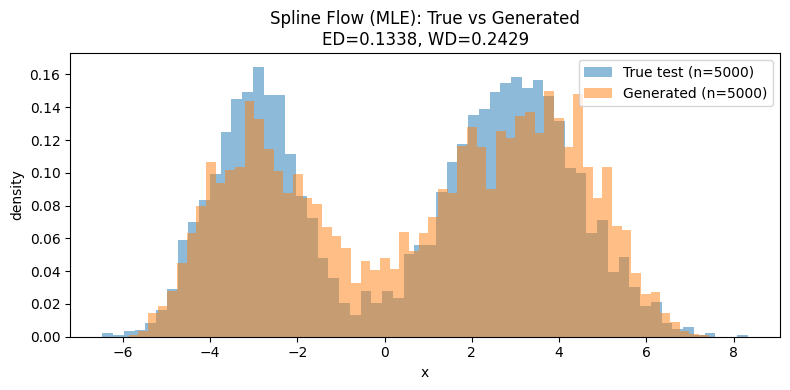

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
flow = train_flow_mle_stack(
    x, n_layers=6, K=64, B=12.0,
    steps=8000, batch_size=256, lr=2e-3, device=device
)
# flow = train_flow_mle(x, K=32, B=10.0, steps=4000, batch_size=256, lr=5e-3, device=device)
x_gen = flow_sample(flow, n=5000, device=device, seed=7)
# report distances + plot
ed, wd = evaluate_and_plot(x, x_gen, title="Spline Flow (MLE): True vs Generated")


### Explore model behavior and the distance between two components in the mixture of Gaussians

In [9]:
# -------------------------
# Data generators
# -------------------------
def sample_mog_np(n, pi, mu1, s1, mu2, s2, seed):
    rng = np.random.default_rng(seed)
    z = rng.binomial(1, pi, size=n)
    x = np.where(
        z == 1,
        rng.normal(mu1, s1, size=n),
        rng.normal(mu2, s2, size=n),
    )
    return x.astype(np.float64)

def sample_mog_torch(n, pi, mu1, s1, mu2, s2, seed, device):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    z = torch.bernoulli(torch.full((n,), pi, device=device), generator=g)
    x = torch.where(
        z == 1,
        torch.normal(mu1, s1, size=(n,), generator=g, device=device),
        torch.normal(mu2, s2, size=(n,), generator=g, device=device),
    )
    return x

# -------------------------
# Metrics
# -------------------------
def compute_metrics(x_true, x_gen):
    ed = energy_distance(x_true, x_gen)
    wd = wasserstein_distance(x_true, x_gen)
    return ed, wd

# -------------------------
# Main sweep
# -------------------------
def sweep_mu1(
    mu1_grid,
    *,
    mu2=3.0, s1=1.0, s2=1.5, pi=0.4,
    n_train=5000, n_test=5000, n_gen=5000,
    train_seed=0, test_seed=1, gen_seed=2,
    device="cpu",
    # Flow hyperparams
    flow_K=32, flow_B=10.0, flow_steps=3000, flow_batch=256, flow_lr=5e-3
):
    rows = []

    for mu1 in mu1_grid:
        delta = abs(mu2 - mu1)

        # ---- data ----
        x_train_t = sample_mog_torch(n_train, pi, mu1, s1, mu2, s2, train_seed, device)
        x_test = sample_mog_np(n_test, pi, mu1, s1, mu2, s2, test_seed)

        # ===== Model 1: Spline Flow (MLE) =====
        G = train_engression(x_train_t, steps=4000, batch_size=256, lr=2e-4, z_dim=8, m=8, device=device)
        x_eng = sample_from_G(G, n=n_gen, z_dim=8, device=device)
        ed_eng, wd_eng = compute_metrics(x_test, x_eng)

        # ===== Model 2: Spline Flow (MLE) =====
        flow = train_flow_mle_stack(
            x_train_t,
            K=flow_K, B=flow_B,
            steps=flow_steps, batch_size=flow_batch, lr=flow_lr,
            device=device
        )
        x_flow = flow_sample(flow, n=n_gen, device=device, seed=gen_seed)
        ed_flow, wd_flow = compute_metrics(x_test, x_flow)

        rows.append({
            "mu1": mu1,
            "mu2": mu2,
            "delta": delta,
            "ED_eng": ed_eng,
            "WD_eng": wd_eng,
            "ED_flow": ed_flow,
            "WD_flow": wd_flow,
        })

        print(f"mu1={mu1:6.2f}  Δ={delta:5.2f} | Flow ED={ed_flow:.4f} WD={wd_flow:.4f} | Engression ED={ed_eng:.4f} WD={wd_eng:.4f}")

    return pd.DataFrame(rows)

# -------------------------
# Plot helpers
# -------------------------
def plot_metric_curves(df):
    df = df.sort_values("delta")

    plt.figure(figsize=(7,4))
    plt.plot(df["delta"], df["WD_flow"], marker="o", label="Flow (MLE) WD")
    plt.plot(df["delta"], df["WD_eng"], marker="o", label="Engression WD")
    plt.xlabel("Separation Δ = |mu2 - mu1|")
    plt.ylabel("Wasserstein distance (true test vs generated)")
    plt.title("Wasserstein distance vs component separation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(df["delta"], df["ED_flow"], marker="o", label="Flow (MLE) ED")
    plt.plot(df["delta"], df["ED_eng"], marker="o", label="Engression ED")
    plt.xlabel("Separation Δ = |mu2 - mu1|")
    plt.ylabel("Energy distance (true test vs generated)")
    plt.title("Energy distance vs component separation")
    plt.legend()
    plt.tight_layout()
    plt.show()

[Engression] step=  500  loss=0.8161
[Engression] step= 1000  loss=0.8230
[Engression] step= 1500  loss=0.9049
[Engression] step= 2000  loss=0.8337
[Engression] step= 2500  loss=0.8525
[Engression] step= 3000  loss=0.8177
[Engression] step= 3500  loss=0.8628
[Engression] step= 4000  loss=0.8277
[FlowStack MLE] step=  500  NLL=-9.7111
[FlowStack MLE] step= 1000  NLL=-15.7057
[FlowStack MLE] step= 1500  NLL=-16.6480
[FlowStack MLE] step= 2000  NLL=-17.0005
[FlowStack MLE] step= 2500  NLL=-17.1171
mu1=  2.00  Δ= 1.00 | Flow ED=0.0458 WD=0.0744 | Engression ED=0.0164 WD=0.0239
[Engression] step=  500  loss=1.1476
[Engression] step= 1000  loss=1.0772
[Engression] step= 1500  loss=1.0865
[Engression] step= 2000  loss=1.1593
[Engression] step= 2500  loss=1.1698
[Engression] step= 3000  loss=1.0781
[Engression] step= 3500  loss=1.1726
[Engression] step= 4000  loss=1.1863
[FlowStack MLE] step=  500  NLL=-8.1673
[FlowStack MLE] step= 1000  NLL=-14.8006
[FlowStack MLE] step= 1500  NLL=-15.6784
[F

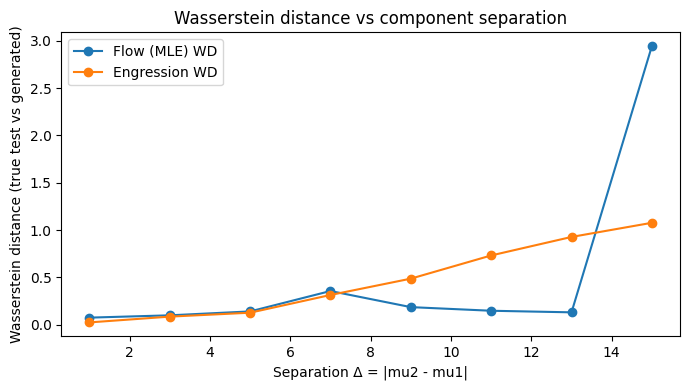

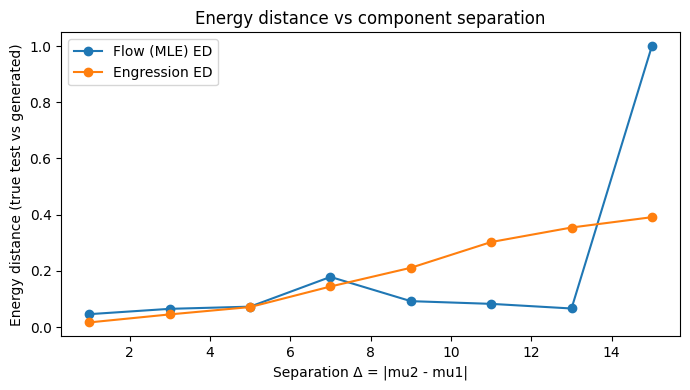

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

mu2 = 3.0
mu1_grid = np.linspace(2.0, -12.0, 8)  # moves left -> increases Δ
# Example: [ 2, 0, -2, -4, -6, -8, -10, -12 ] (Δ from 1 to 15)

df = sweep_mu1(
    mu1_grid,
    mu2=mu2, s1=1.0, s2=1.5, pi=0.4,
    n_train=5000, n_test=5000, n_gen=5000,
    train_seed=0, test_seed=1, gen_seed=2,
    device=device,
    flow_steps=2500,  # speed/quality tradeoff
    flow_B=12.0       # cover support as mu1 goes far left
)

plot_metric_curves(df)